# MIDI-to-audio Generation Notebook

<div style="text-align:center;">
<img src="../images/method.png" alt="Example Image" width="800" />
</div>


This notebook implements the inference for MIDI-to-audio generation. We demonstrate using the demo samples from the [webpage](https://nilsdem.github.io/control-transfer-diffusion/), but you can load your own midi files and timbre targets. 
Please note that although any MIDI file can be used, the model require samples from the datasets (or quite similar) for the timbre target.

Make sure to [download]() the pretrained models and place them in `./pretrained`. The only checkpoint available so far was trained on the [SLAKH 2100](http://www.slakh.com/) dataset.

### Some imports

In [1]:
import gin
gin.enter_interactive_mode()

from IPython.display import display, Audio
import pretty_midi
import matplotlib.pyplot as plt

import torch
import numpy as np
import librosa

import sys
sys.path.append('..')

torch.set_grad_enabled(False)

### Checkpoint setup

In [2]:
# Import paths
folder = "../pretrained/slakh_midi/"
checkpoint_path = folder + "checkpoint.pt"
autoencoder_path = "../pretrained/AE_slakh.pt"
config = folder + "config.gin"

# GPU
device = "cpu"  # or "cpu"

### Load the model

In [3]:
from diffusion.model import EDM_ADV

# Parse config
gin.parse_config_file(config)
SR = gin.query_parameter("%SR")
audio_length = gin.query_parameter("%X_LENGTH")

# Instantiate model
blender = EDM_ADV()

# Load checkpoints
state_dict = torch.load(checkpoint_path, map_location="cpu")["model_state"]
blender.load_state_dict(state_dict, strict=False)

emb_model = torch.jit.load(autoencoder_path).eval().to(device)

# Send to device
blender = blender.eval().to(device)

/var/folders/_p/x72hk_rn5hjd7q0c1c8bm1dh0000gn/T/ipykernel_46661/1121100465.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(checkpoint_path, map

### Loading some audio files

In [4]:
def load_audio(path, sr):
    audio_full, sr = librosa.load(path, sr=sr)
    audio = audio_full[:audio_length]
    audio = torch.from_numpy(audio).reshape(1, 1, -1) / audio.max()
    return audio


def process_audio(audio):
    audio = audio.to(device)
    z = emb_model.encode(audio)
    return z


def normalize(S):
    S = (S - np.min(S)) / (np.max(S) - np.min(S) + 1e-4)
    return S


def get_midi(file, audio_length, comp_ratio, sr):
    midi_data = pretty_midi.PrettyMIDI(file)
    length = audio_length
    tstart = 0
    tend = length
    midi_data.adjust_times([0, tend], [0, tend])

    pr = midi_data.get_piano_roll(
        times=np.linspace(0, audio_length / sr, audio_length // comp_ratio))

    pr = normalize(pr)
    return pr

In [5]:
audio_file = '../audios/midi/true/voice.wav'
midi_file = "../audios/midi/midi/voice.mid"

Sample 1


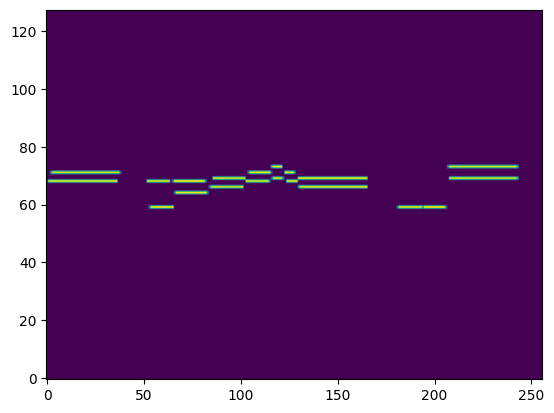

In [6]:
audio1 = load_audio(audio_file, sr=SR)

print("Sample 1")
display(Audio(audio1.squeeze(), rate=SR))

# Compute embeddings and CQT
z1 = process_audio(audio1)

# Get audio length and compression ratio
audio_length = audio1.shape[-1]
comp_ratio = audio_length // z1.shape[-1]

# Load the midi

pr = get_midi(midi_file, audio_length, comp_ratio, SR)
plt.imshow(pr, aspect="auto", origin="lower")

### Generation

In [7]:
nb_steps = 60  #Number of diffusion steps
guidance = 2.0  #Classifier free guidance strength

In [8]:
# Compute structure representation
time_cond = torch.from_numpy(pr).reshape(1, pr.shape[-2],
                                         pr.shape[-1]).float().to(device)

time_cond = blender.encoder_time(time_cond)

# Compute timbre representation
zsem = blender.encoder(z1)

# Sample initial noise
x0 = torch.randn_like(z1)

xS = blender.sample(x0,
                    time_cond=time_cond,
                    zsem=zsem,
                    nb_step=nb_steps,
                    guidance=guidance,
                    guidance_type="time_cond")

audio_out = emb_model.decode(xS).cpu().numpy().squeeze()
display(Audio(audio_out, rate=SR))

/Users/demerle/anaconda3/envs/test_imsir/lib/python3.10/site-packages/torch/nn/modules/conv.py:370: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/Convolution.cpp:1037.)
  return F.conv1d(
100%|██████████| 60/60 [00:07<00:00,  8.40step/s]
